# Deep RL Assignment 1: Imitation Learning
The goal of this assignment is to experiment with imitation learning, including direct behavior cloning and the DAgger algorithm. In lieu of a human demonstrator, demonstrations will be provided via an expert policy that we have trained for you. Your goals will be to set up behavior cloning and DAgger, and compare their performance on a few different continuous control tasks from the OpenAI Gym benchmark suite.

## Section 2: Behavioral Cloning

### Section 2.2: Implement behavior cloning and report results on two tasks

Here, I run the expert model 20 times to generate 20k expert training data. 
With **Keras**, I built a a neural network with 4 fully connected hidden layers, 64 neurons per layer for the first 3 layers, and 32 neurons in the last layer,  with “relu” activation. Among the 20k input data,  25% are used as validation data. I repeated training process 10 iterations. 

In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
import pickle
import gym
import argparse
import tf_util


# load the expert data
with open('expert_data/Ant-v2.pkl', 'rb') as f:
    data = pickle.load(f)
#with open('expert_data/Hopper-v2.pkl', 'rb') as f:
#    data = pickle.load(f)

observations = data['observations']
actions = data['actions']
actions = np.reshape(actions, (len(actions), actions.shape[-1]))

n_obs = observations.shape[-1]
n_act = actions.shape[-1]

# build a keras model
model = Sequential([
    Dense(128, input_shape=(n_obs,)), Activation('relu'),
    Dense(128), Activation('relu'),
    Dense(128), Activation('relu'),
    Dense(128), Activation('relu'),
    Dense(n_act)])

# For a mean squared error regression problem
model.compile(optimizer='rmsprop',
              loss='mse')



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Applied neural network to original starting point and compare the sequence.
Notice that this step is run in the command line as "python behave_clone.py Hopper-v2 --render --num_rollouts 20". This is not easily run in ipython Notebook here because of argparse. Therefore I will skip the following scripts and report the results from the command line.

In [ ]:
# run trained model
parser = argparse.ArgumentParser()
parser.add_argument('envname', type=str)
parser.add_argument('--render', action='store_true')
parser.add_argument("--max_timesteps", type=int)
parser.add_argument('--num_rollouts', type=int, default=20,
                    help='Number of expert roll outs')
args = parser.parse_args()

 
with tf.Session():
    tf_util.initialize()

    # Fit the data
    model.fit(observations, actions, epochs=20, batch_size=32, validation_split=0.25)

    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []

    for i in range(args.num_rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = model.predict(obs[None,:])
            observations.append(obs)
            actions.append([action])
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if args.render:
                env.render()
            if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                break
        returns.append(totalr)
    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

This is the comparison between expert trainning and behavior cloning.
I tested two tasks: Ant and Hopper.
You can see that Ant performs well within 5sigma compared with expert,
but Hopper doesn't work very well. 

task	|               Mean	|std
-          |          -  | - |
Ant-expert	    |        4852|	90
Ant-behavior cloning| 	 4330	| 117
Hopper-expert	     |     3778	| 4
Hopper-Behavior cloning	|  350	| 182

## Section 2.3: Experiment with hyperparameter - number of training epochs.

Experiment with the hyperparameter - number of training epochs, that affects the performance of the behavioral cloning agent. For the Ant task used in the previous question, I show a graph of how the BC agent’s performance varies with the value of this hyperparameter.

The result showing is calcualted using same script in Section 2.2, but with different number of training epochs.

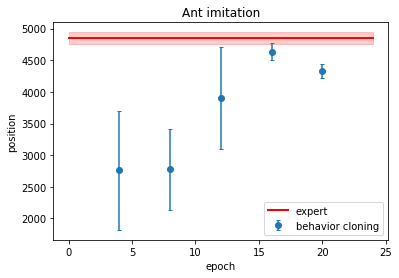

In [11]:
import matplotlib.pyplot as plt
real = 4852
real_std = 90
epochs = [4, 8, 12, 16, 20]
means = [2758, 2774, 3905, 4635, 4330]
stds = [939, 647, 803, 136, 117]
plt.clf()
plt.fill_between([0,24],[real-real_std, real-real_std], [real+real_std, real+real_std], color='r', alpha=0.2)
plt.plot([0,24],[real,real],ls='-',lw=2,color='r',label='expert')
plt.errorbar(epochs, means, yerr=stds, fmt='o', capsize=2,label='behavior cloning')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('position')
plt.title('Ant imitation')
plt.savefig('bc.png',format='png')
plt.show()

This plot shows how the how the BC agent’s performance varies with the number of epochs. We can see the Behavior learned position becomes more accurate (approaches the expert position) and prices (smaller standard deviation) as we use more epochs. This is because the more epochs we trained the NN, the better our model is. Therefore hereafter, I will use 16 training epochs.

## Section 3: DAgger
Implemented and run DAgger. Here I'll show a task in which DAgger can learn a better policy than behavioral cloning. In this section, I also use similar dataset and neural network as I mentioned before:  I run the expert model 20 times to generate 20k expert training data. , I built a neural network with 4 fully connected hidden layers, 64 neurons per layer for the first 3 layers, and 32 neurons in the last layer,  with “relu” activation. Among the 20k input data,  25% are used as validation data. Notice that I use epochs = 16 based on previous plot.

In [10]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)
"""

import os
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import argparse
from keras.models import Sequential
from keras.layers import Dense, Activation
import pdb

def main(iters=10):
    # load the expert data
    with open('expert_data/Hopper-v2.pkl', 'rb') as f:
        data = pickle.load(f)
    
    observations_exp = data['observations']
    actions_exp_orig = data['actions']
    actions_exp = np.reshape(actions_exp_orig, (len(actions_exp_orig), actions_exp_orig.shape[-1]))
    
    n_obs = observations_exp.shape[-1]
    n_act = actions_exp.shape[-1]
    
    # build a keras model
    model = Sequential([
        Dense(64, input_shape=(n_obs,)), Activation('relu'),
        Dense(64), Activation('relu'),
        Dense(64), Activation('relu'),
        Dense(32), Activation('relu'),
        Dense(n_act)])
    
    # For a mean squared error regression problem
    model.compile(optimizer='rmsprop',
                  loss='mse')
    
    # run trained model
    parser = argparse.ArgumentParser()
    parser.add_argument('expert_policy_file', type=str)
    parser.add_argument('envname', type=str)
    parser.add_argument('--render', action='store_true')
    parser.add_argument("--max_timesteps", type=int)
    parser.add_argument('--num_rollouts', type=int, default=20,
                        help='Number of expert roll outs')
    args = parser.parse_args()

    print('loading and building expert policy')
    policy_fn = load_policy.load_policy(args.expert_policy_file)
    print('loaded and built')


    import gym
    means = []
    stds = []
    with tf.Session():
        tf_util.initialize()
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit
        
        for it in range(iters):

            # Fit the data
            model.fit(observations_exp, actions_exp, epochs=16, batch_size=32, validation_split=0.25)

            returns = []
            new_observations = []
            new_actions = []
            for i in range(args.num_rollouts):
                print('iter', i)
                obs = env.reset()
                done = False
                totalr = 0.
                steps = 0
                while not done:
                    action = model.predict(obs[None,:])
                    new_observations.append(obs)
                    new_actions.append([action])
                    obs, r, done, _ = env.step(action)
                    totalr += r
                    steps += 1
                    if args.render:
                        env.render()
                    if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                    if steps >= max_steps:
                        break
                returns.append(totalr)

            print('{0} interation'.format(it))
            print('returns', returns)
            print('mean return', np.mean(returns))
            print('std of return', np.std(returns))
            means.append(np.mean(returns))
            stds.append(np.std(returns))

            # add new observations and corresponding expert actions to the original data #observations_exp = list(data['observations'])
            #actions_exp = list(data['actions'])
            exp_actions = []
            for obs in new_observations:
                #observations_exp.append(obs)
                exp_actions.append(policy_fn(obs[None,:]))

            first_dim = np.array(exp_actions).shape[0]
            last_dim  = np.array(exp_actions).shape[2]
            observations_exp = np.concatenate((observations_exp, np.array(new_observations)), 0)
            actions_exp = np.concatenate((actions_exp, np.reshape(np.array(exp_actions), [first_dim, last_dim])), 0)
            print(means)
            print(stds)


Similar as before, here I only report the results I ran from calling the previous script in the command line. I plot the number of DAgger iterations vs. the policy’s mean return, with error bars to show the standard deviation. Include the performance of the expert policy and the behavioral cloning agent on the same plot. 


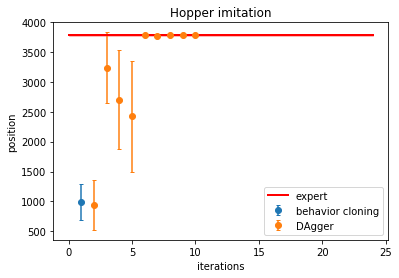

In [18]:
real = 3778
real_std = 4
bc = 993
bc_std = 303
means= [993, 945, 3239, 2700, 2423, 3777, 3769, 3776, 3786, 3781]
stds=[303, 421, 590, 824, 928, 8, 18, 3, 4.2, 3.5]

plt.clf()
plt.fill_between([0,24],[real-real_std, real-real_std], [real+real_std, real+real_std], color='r', alpha=0.2)
plt.plot([0,24],[real,real],ls='-',lw=2,color='r',label='expert')
plt.errorbar(1, bc, yerr=bc_std, fmt='o', capsize=2, label='behavior cloning')
plt.errorbar(np.arange(9)+2, means[1:], yerr=stds[1:], fmt='o', capsize=2,label='DAgger')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('position')
plt.title("Hopper imitation")
plt.savefig('dagger.png',format='png')
plt.show()